In [165]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

from datetime import datetime
import pytz

from pymongo import MongoClient
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

In [70]:
from Functions import Read_data as RD
yesterday = datetime.now() - relativedelta(days=7)
dfs = RD.load_data('BNB', start_date=yesterday)

Split data into 5 continuous segments


In [123]:
dfs[0].timestamp

0      2025-03-20 19:13:21
1      2025-03-20 19:13:30
2      2025-03-20 19:13:38
3      2025-03-20 19:13:46
4      2025-03-20 19:13:54
               ...        
2018   2025-03-20 23:42:00
2019   2025-03-20 23:42:08
2020   2025-03-20 23:42:15
2021   2025-03-20 23:42:23
2022   2025-03-20 23:42:31
Name: timestamp, Length: 2023, dtype: datetime64[ns]

In [4]:
dfs[0].head()

,timestamp,mid_price,spread,bid_vol_level_1,ask_vol_level_1,imbalance_level_1,bid_vol_level_2,ask_vol_level_2,imbalance_level_2,bid_vol_level_3,...,volume_imbalance,bid_vwap,ask_vwap,bid_slope,ask_slope,book_pressure_ratio,large_bid_distance_bps,large_ask_distance_bps,bid_liquidity_top3_pct,ask_liquidity_top3_pct
0,2025-03-20 19:13:21,635.355,0.01,20.102,1.093,0.948431,8.610,0.036,0.995836,7.080,...,0.409374,630.581610,640.183781,5.931825,-4.134032,0.504550,36.515019,33.681957,0.028237,0.038790
1,2025-03-20 19:13:30,635.365,0.01,16.608,19.361,0.461731,6.366,2.251,0.738772,0.027,...,0.408483,630.557560,640.183051,5.702816,-4.264170,0.284496,36.671834,33.524037,0.016719,0.040583
2,2025-03-20 19:13:38,635.205,0.01,9.148,10.462,0.466497,0.036,2.871,0.012384,0.456,...,0.404716,630.500082,640.110607,6.145607,-3.341452,0.418425,34.162200,43.922828,0.026314,0.042755
3,2025-03-20 19:13:46,635.255,0.01,0.036,23.218,0.001548,0.036,14.915,0.002408,1.678,...,0.404232,630.503973,640.114395,5.810055,-3.811922,0.312379,34.946596,43.132285,0.022870,0.049675
4,2025-03-20 19:13:54,635.135,0.01,9.421,25.835,0.267217,0.871,0.018,0.979753,0.027,...,0.399885,630.530703,640.003561,6.520621,-3.952096,0.446610,33.221284,45.029797,0.024508,0.036566


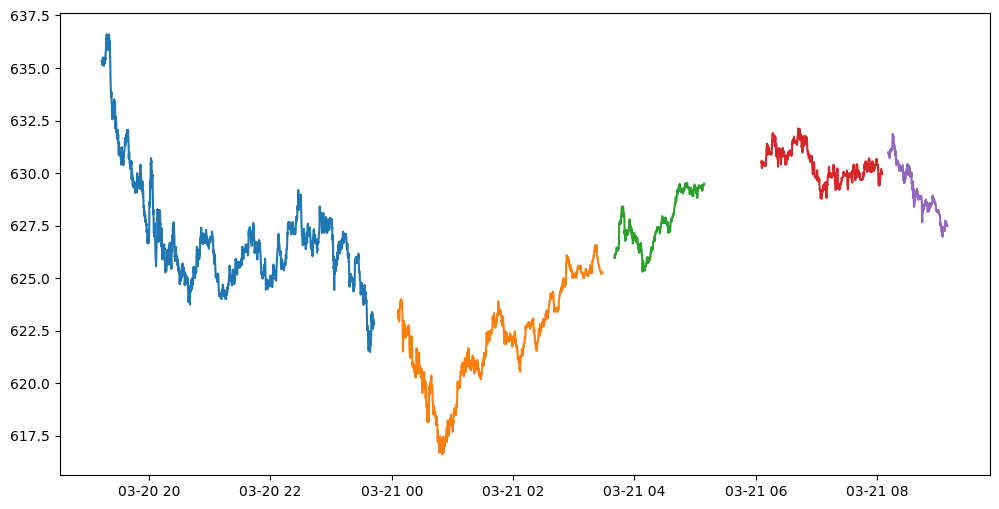

In [7]:
plt.figure(figsize=(12,6))
for df in dfs:
    plt.plot(df['timestamp'],df['mid_price'])
plt.show()

In [85]:
def analyze_queue_depletion(dfs):
    all_results = []
    
    for df in dfs:
        if len(df) < 2 or 'mid_price' not in df.columns:
            continue
            
        df_copy = df.copy()
        
        df_copy['next_mid_price'] = df_copy['mid_price'].shift(-1)
        df_copy['price_change'] = df_copy['next_mid_price'] - df_copy['mid_price']
        
        df_copy['next_spread'] = df_copy['spread'].shift(-1)
        df_copy['spread_change'] = df_copy['next_spread'] - df_copy['spread']
        
        df_copy['ask_depleted'] = df_copy['price_change'] > 0
        df_copy['bid_depleted'] = df_copy['price_change'] < 0
        
        df_copy['spread_widened'] = df_copy['spread_change'] > 0
        df_copy['ask_widened'] = df_copy['spread_widened'] & df_copy['ask_depleted']
        df_copy['bid_widened'] = df_copy['spread_widened'] & df_copy['bid_depleted']
        
        df_copy['depletion_type'] = 'none'
        df_copy.loc[df_copy['ask_depleted'], 'depletion_type'] = 'ask'
        df_copy.loc[df_copy['bid_depleted'], 'depletion_type'] = 'bid'
        
        depletion_events = df_copy[(df_copy['ask_depleted'] | df_copy['bid_depleted'])].copy()
        
        if len(depletion_events) == 0:
            continue
            
        depletion_events['level1_imbalance'] = depletion_events['imbalance_level_1']
        
        depletion_events = depletion_events.dropna(subset=['level1_imbalance'])
        
        all_results.append(depletion_events[['level1_imbalance', 'depletion_type', 
                                             'spread_widened', 'ask_widened', 'bid_widened']])
    
    if not all_results:
        print("No depletion events found")
        return None
    
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # Add is_ask_depleted as numeric 0/1 for regression
    combined_results['is_ask_depleted'] = (combined_results['depletion_type'] == 'ask').astype(int)
    
    # Create raw data for fitting
    raw_data = combined_results[['level1_imbalance', 'is_ask_depleted']].copy()
    
    # Continue with binning for the probability table
    bins = np.linspace(0, 1, 21) 
    bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    combined_results['imbalance_bin'] = pd.cut(combined_results['level1_imbalance'], bins=bins, labels=bin_labels)
    
    probabilities = []
    for bin_label in bin_labels:
        bin_data = combined_results[combined_results['imbalance_bin'] == bin_label]
        if len(bin_data) > 0:
            ask_depleted_count = sum(bin_data['depletion_type'] == 'ask')
            total_count = len(bin_data)
            prob_ask_depletes_first = ask_depleted_count / total_count
            
            spread_widened_count = sum(bin_data['spread_widened'])
            prob_spread_widens = spread_widened_count / total_count if total_count > 0 else 0
            
            ask_widened_count = sum(bin_data['ask_widened'])
            spread_widened_and_price_up = sum(bin_data['ask_widened'] & (bin_data['depletion_type'] == 'ask'))
            prob_price_up_when_ask_widens = spread_widened_and_price_up / ask_widened_count if ask_widened_count > 0 else 0
            
            bid_widened_count = sum(bin_data['bid_widened'])
            spread_widened_and_price_down = sum(bin_data['bid_widened'] & (bin_data['depletion_type'] == 'bid'))
            prob_price_down_when_bid_widens = spread_widened_and_price_down / bid_widened_count if bid_widened_count > 0 else 0
            
            probabilities.append({
                'imbalance_bin': bin_label,
                'imbalance_midpoint': (float(bin_label.split('-')[0]) + float(bin_label.split('-')[1])) / 2,
                'prob_ask_depletes_first': prob_ask_depletes_first,
                'prob_bid_depletes_first': 1 - prob_ask_depletes_first,
                'prob_spread_widens': prob_spread_widens,
                'prob_price_up_when_ask_widens': prob_price_up_when_ask_widens,
                'prob_price_down_when_bid_widens': prob_price_down_when_bid_widens,
                'total_events': total_count,
                'ask_widened_events': ask_widened_count,
                'bid_widened_events': bid_widened_count
            })
    
    result_df = pd.DataFrame(probabilities)
    return result_df, raw_data


def plot_queue_depletion_probability(result_df):
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    ax1.plot(result_df['imbalance_midpoint'], result_df['prob_ask_depletes_first'], 'b-', linewidth=2)
    ax1.set_xlabel('Level 1 Queue Imbalance (Bid Volume / Total Volume)')
    ax1.set_ylabel('Probability Ask Queue Depletes First', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    
    ax2 = ax1.twinx()
    
    bars = ax2.bar(result_df['imbalance_midpoint'], result_df['total_events'], 
             alpha=0.3, width=0.04, color='gray')
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', rotation=0)
    
    ax2.set_ylabel('Number of Samples', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title('Probability of Ask Queue Depleting First vs. Level 1 Queue Imbalance')
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig

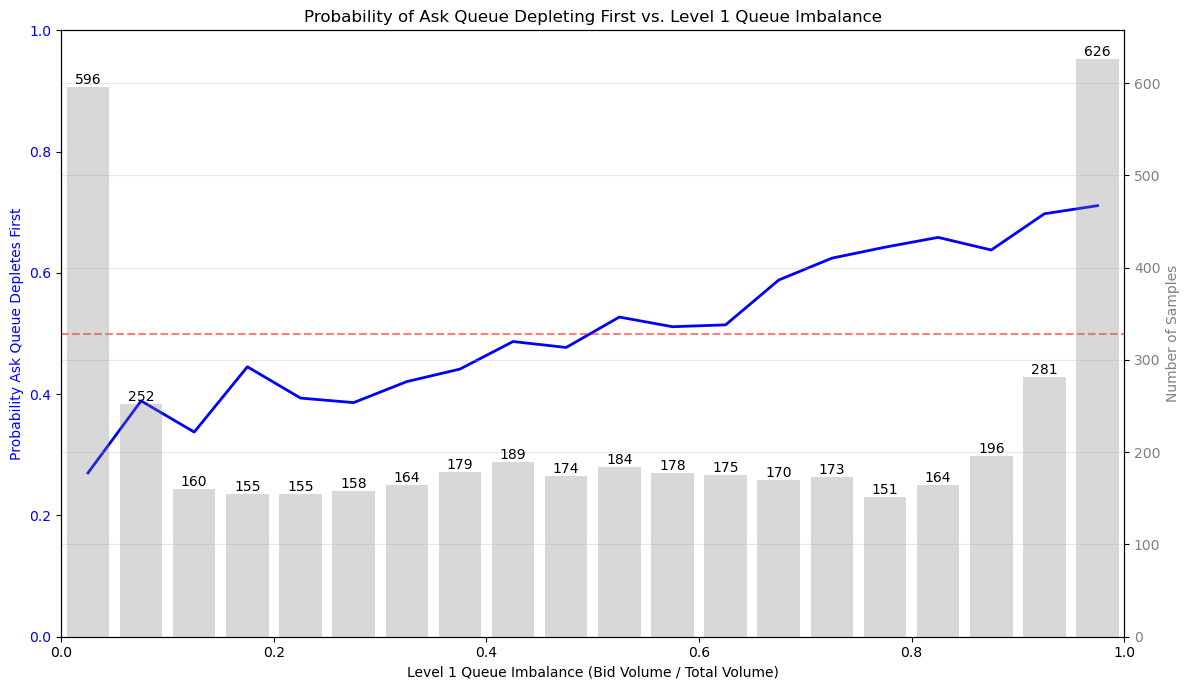

In [91]:
result_df, raw_depletion_data = analyze_queue_depletion(dfs)
plot_queue_depletion_probability(result_df)
plt.show()

In [117]:
def analyze_imbalance_price_relation(dfs):
    all_data = []
    
    for df in dfs:
        if len(df) < 2 or 'mid_price' not in df.columns or 'imbalance_level_1' not in df.columns:
            continue
            
        df_copy = df.copy()
        
        df_copy['next_mid_price'] = df_copy['mid_price'].shift(-1)
        df_copy['price_change'] = df_copy['next_mid_price'] - df_copy['mid_price']
        
        df_copy['pct_price_change'] = df_copy['price_change'] / df_copy['mid_price']
        
        valid_data = df_copy.dropna(subset=['imbalance_level_1', 'price_change']).copy()
        
        if len(valid_data) > 0:
            all_data.append(valid_data[['imbalance_level_1', 'price_change', 'pct_price_change', 'mid_price']])
    
    if not all_data:
        print("No valid data found for regression analysis")
        return None
    
    combined_data = pd.concat(all_data, ignore_index=True)
    
    X = combined_data['imbalance_level_1'].values.reshape(-1, 1)
    y_abs = combined_data['price_change'].values
    y_pct = combined_data['pct_price_change'].values
    
    model_abs = LinearRegression()
    model_abs.fit(X, y_abs)
    
    model_pct = LinearRegression()
    model_pct.fit(X, y_pct)

    combined_data['predicted_price_change'] = model_abs.predict(X)
    combined_data['predicted_pct_change'] = model_pct.predict(X)
    
    r2_abs = model_abs.score(X, y_abs)
    r2_pct = model_pct.score(X, y_pct)
    
    mse_abs = np.mean((combined_data['predicted_price_change'] - combined_data['price_change'])**2)
    mse_pct = np.mean((combined_data['predicted_pct_change'] - combined_data['pct_price_change'])**2)
    
    corr_abs = np.corrcoef(combined_data['imbalance_level_1'], combined_data['price_change'])[0, 1]
    corr_pct = np.corrcoef(combined_data['imbalance_level_1'], combined_data['pct_price_change'])[0, 1]
    
    results = {
        'absolute_price_change': {
            'slope': model_abs.coef_[0],
            'intercept': model_abs.intercept_,
            'r_squared': r2_abs,
            'mse': mse_abs,
            'correlation': corr_abs,
            'equation': f"price_change = {model_abs.coef_[0]:.8f} * imbalance + {model_abs.intercept_:.8f}"
        },
        'percentage_price_change': {
            'slope': model_pct.coef_[0],
            'intercept': model_pct.intercept_,
            'r_squared': r2_pct,
            'mse': mse_pct,
            'correlation': corr_pct,
            'equation': f"pct_price_change = {model_pct.coef_[0]:.8f} * imbalance + {model_pct.intercept_:.8f}"
        },
        'sample_size': len(combined_data),
        'average_price': combined_data['mid_price'].mean(),
        'model_abs': model_abs,
        'model_pct': model_pct
    }
    
    return results, combined_data

def plot_complete_analysis(results, data, result_df, raw_depletion_data):
    
    plt.figure(figsize=(8, 6))
    plt.scatter(data['imbalance_level_1'], data['price_change'], alpha=0.3, s=5)
    
    x_range = np.linspace(0, 1, 100)
    y_pred = results['absolute_price_change']['slope'] * x_range + results['absolute_price_change']['intercept']
    
    plt.plot(x_range, y_pred, 'r-', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    
    plt.xlabel('Level 1 Imbalance')
    plt.ylabel('Price Change')
    plt.title(f"Absolute Price Change vs. Imbalance\n{results['absolute_price_change']['equation']}\nR² = {results['absolute_price_change']['r_squared']:.4f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(data['imbalance_level_1'], data['pct_price_change'], alpha=0.3, s=5)
    
    y_pred_pct = results['percentage_price_change']['slope'] * x_range + results['percentage_price_change']['intercept']
    
    plt.plot(x_range, y_pred_pct, 'r-', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    
    plt.xlabel('Level 1 Imbalance')
    plt.ylabel('Percentage Price Change')
    plt.title(f"Percentage Price Change vs. Imbalance\n{results['percentage_price_change']['equation']}\nR² = {results['percentage_price_change']['r_squared']:.4f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    
    plt.scatter(result_df['imbalance_midpoint'], result_df['prob_ask_depletes_first'], 
                s=result_df['total_events']/2, color='blue', alpha=0.7,
                label='Binned probabilities')
    
    X_raw = raw_depletion_data['level1_imbalance'].values.reshape(-1, 1)
    y_raw = raw_depletion_data['is_ask_depleted'].values
    
    model_raw = LinearRegression()
    model_raw.fit(X_raw, y_raw)
    
    y_pred_raw = model_raw.predict(np.array(x_range).reshape(-1, 1))
    
    plt.plot(x_range, y_pred_raw, 'r-', linewidth=2, 
             label=f"Linear fit: y = {model_raw.coef_[0]:.4f}x + {model_raw.intercept_:.4f}")
    
    r2_raw = model_raw.score(X_raw, y_raw)
    
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Probability of Ask Depleting First vs. Imbalance\nR² = {r2_raw:.4f}")
    plt.xlabel('Level 1 Imbalance')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

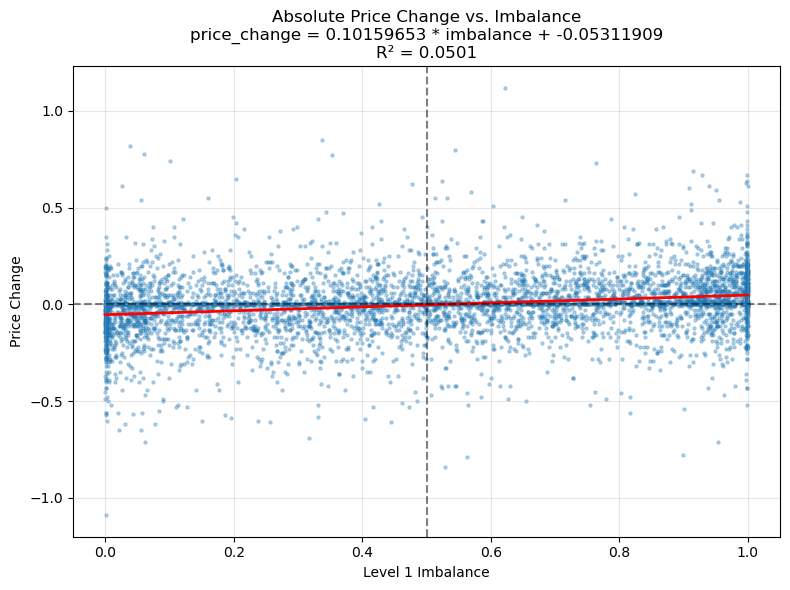

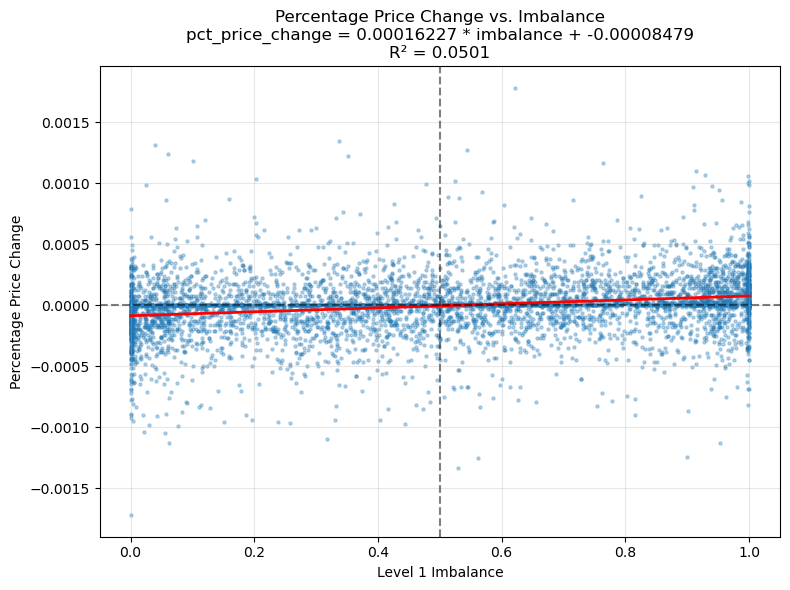

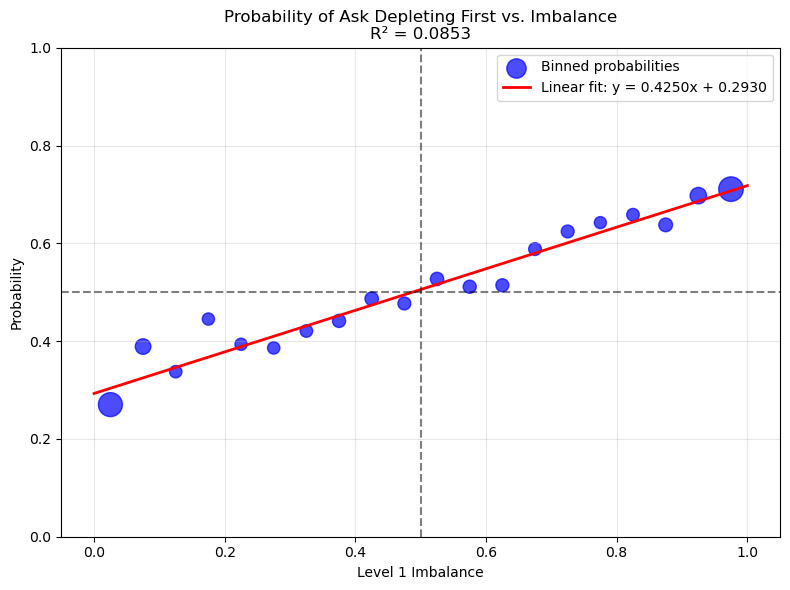

In [121]:
results, data = analyze_imbalance_price_relation(dfs)
plot_complete_analysis(results, data, result_df, raw_depletion_data)

In [213]:
def analyze_queue_depletion_hazard(dfs):
    
    all_depletion_events = []
    
    for df_idx, df in enumerate(dfs):
        if len(df) < 2 or 'mid_price' not in df.columns or 'timestamp' not in df.columns:
            continue
            
        df_copy = df.copy()
        
        if not pd.api.types.is_datetime64_any_dtype(df_copy['timestamp']):
            df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
        
        df_copy['next_mid_price'] = df_copy['mid_price'].shift(-1)
        df_copy['price_change'] = df_copy['next_mid_price'] - df_copy['mid_price']
        
        df_copy['ask_depleted'] = df_copy['price_change'] > 0
        df_copy['bid_depleted'] = df_copy['price_change'] < 0
        df_copy['any_depleted'] = df_copy['ask_depleted'] | df_copy['bid_depleted']
        
        change_points = df_copy.index[df_copy['any_depleted']]
        
        for i in range(len(change_points) + 1):
            if i == 0:
                start_idx = 0
            else:
                start_idx = change_points[i-1] + 1
                
            if i == len(change_points):
                end_idx = len(df_copy) - 1
                event_occurred = False
                event_type = 'censored'
            else:
                end_idx = change_points[i]
                event_occurred = True
                event_type = 'ask_depleted' if df_copy.loc[end_idx, 'ask_depleted'] else 'bid_depleted'
            
            if start_idx >= end_idx:
                continue
                
            segment = df_copy.iloc[start_idx:end_idx+1]
            
            start_time = segment['timestamp'].iloc[0]
            end_time = segment['timestamp'].iloc[-1]
            duration = (end_time - start_time).total_seconds()
            
            n_timestamps = len(segment)
            
            initial_imbalance = segment['imbalance_level_1'].iloc[0]
            
            if pd.isna(initial_imbalance):
                continue
                
            all_depletion_events.append({
                'df_idx': df_idx,
                'segment_idx': i,
                'start_time': start_time,
                'end_time': end_time,
                'duration_seconds': duration,
                'n_timestamps': n_timestamps,
                'initial_imbalance': initial_imbalance,
                'event_occurred': event_occurred,
                'event_type': event_type
            })
    
    if not all_depletion_events:
        print("No depletion events found")
        return None
    
    event_df = pd.DataFrame(all_depletion_events)

    event_df['ask_depleted'] = (event_df['event_type'] == 'ask_depleted').astype(int)
    event_df['bid_depleted'] = (event_df['event_type'] == 'bid_depleted').astype(int)

    avg_duration = event_df['duration_seconds'].mean()
    median_duration = event_df['duration_seconds'].median()
    max_duration = event_df['duration_seconds'].max()
    
    avg_timestamps = event_df['n_timestamps'].mean()
    median_timestamps = event_df['n_timestamps'].median()
    
    bins = np.linspace(0, 1, 5)
    bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    event_df['imbalance_bin'] = pd.cut(event_df['initial_imbalance'], bins=bins, labels=bin_labels)

    binned_data = {}
    for bin_label in bin_labels:
        bin_data = event_df[event_df['imbalance_bin'] == bin_label]
        if len(bin_data) > 10:
            binned_data[bin_label] = {
                'data': bin_data,
                'count': len(bin_data)
            }

    cph = CoxPHFitter()
    cox_data = event_df[['duration_seconds', 'event_occurred', 'initial_imbalance']].copy()
    cox_data['imbalance_dev_from_half'] = abs(cox_data['initial_imbalance'] - 0.5)
    cox_data['favors_ask'] = (cox_data['initial_imbalance'] > 0.5).astype(int)
    cox_data['favors_bid'] = (cox_data['initial_imbalance'] < 0.5).astype(int)
    
    try:
        cph.fit(cox_data, duration_col='duration_seconds', event_col='event_occurred')
        cox_summary = cph.summary
    except Exception as e:
        cox_summary = f"Cox model could not be fitted: {str(e)}"
    
    one_step_df = None
    one_step_hazard = {
        'any_depletion': {},
        'ask_depletion': {},
        'bid_depletion': {}
    }
    median_timestep = None
    
    if 'timestamp' in df.columns:
        timestep_diffs = []
        for df in dfs:
            if 'timestamp' in df.columns and len(df) > 1:
                df_copy = df.copy()
                if not pd.api.types.is_datetime64_any_dtype(df_copy['timestamp']):
                    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])
                timestep_diffs.extend(df_copy['timestamp'].diff().dropna().dt.total_seconds().tolist())
        
        if timestep_diffs:
            median_timestep = np.median(timestep_diffs)
            
            for imbalance in [0.1, 0.3, 0.5, 0.7, 0.9]:
                nearby_events = event_df[(event_df['initial_imbalance'] >= imbalance - 0.1) & 
                                         (event_df['initial_imbalance'] <= imbalance + 0.1)]
                
                if len(nearby_events) > 10:
                    one_step_seconds = median_timestep

                    naf_any = NelsonAalenFitter()
                    naf_any.fit(nearby_events['duration_seconds'], nearby_events['event_occurred'])
                    
                    naf_ask = NelsonAalenFitter()
                    naf_ask.fit(nearby_events['duration_seconds'], nearby_events['ask_depleted'])
                    
                    naf_bid = NelsonAalenFitter()
                    naf_bid.fit(nearby_events['duration_seconds'], nearby_events['bid_depleted'])

                    try:
                        times = sorted(naf_any.cumulative_hazard_.index)
                        if times:
                            closest_time = min(times, key=lambda x: abs(x - one_step_seconds))
                            
                            h_t_any = naf_any.cumulative_hazard_.loc[closest_time].iloc[0]
                            h_t_ask = naf_ask.cumulative_hazard_.loc[closest_time].iloc[0]
                            h_t_bid = naf_bid.cumulative_hazard_.loc[closest_time].iloc[0]
                            
                            one_step_hazard['any_depletion'][imbalance] = h_t_any
                            one_step_hazard['ask_depletion'][imbalance] = h_t_ask
                            one_step_hazard['bid_depletion'][imbalance] = h_t_bid
                    except Exception as e:
                        print(f"Error calculating hazard for imbalance {imbalance}: {e}")
            
            imbalances = sorted(one_step_hazard['any_depletion'].keys())
            if imbalances:
                any_hazards = [one_step_hazard['any_depletion'].get(i, 0) for i in imbalances]
                ask_hazards = [one_step_hazard['ask_depletion'].get(i, 0) for i in imbalances]
                bid_hazards = [one_step_hazard['bid_depletion'].get(i, 0) for i in imbalances]
                
                one_step_df = pd.DataFrame({
                    'imbalance': imbalances,
                    'any_depletion_hazard': any_hazards,
                    'ask_depletion_hazard': ask_hazards,
                    'bid_depletion_hazard': bid_hazards
                })

    hazard_results = {
        'event_data': event_df,
        'binned_data': binned_data,
        'bin_labels': bin_labels,
        'avg_duration_seconds': avg_duration,
        'median_duration_seconds': median_duration,
        'max_duration_seconds': max_duration,
        'avg_timestamps': avg_timestamps,
        'median_timestamps': median_timestamps,
        'cox_summary': cox_summary,
        'one_step_hazard': one_step_df,
        'median_timestep': median_timestep
    }
    
    return hazard_results


def plot_queue_depletion_hazard(hazard_results):
    
    if hazard_results is None:
        print("No hazard results to plot")
        return
    
    event_df = hazard_results['event_data']
    bin_labels = hazard_results['bin_labels']
    one_step_df = hazard_results['one_step_hazard']
    median_timestep = hazard_results['median_timestep']
    
    naf = NelsonAalenFitter()
    
    plt.figure(figsize=(12, 8))

    ax1 = plt.subplot(2, 2, 1)
    for bin_label in bin_labels:
        bin_data = event_df[event_df['imbalance_bin'] == bin_label]
        if len(bin_data) > 10:
            naf.fit(bin_data['duration_seconds'], bin_data['event_occurred'], label=f"Imbalance {bin_label}")
            naf.plot_cumulative_hazard(ax=ax1)
    
    ax1.set_title("Cumulative Hazard Rate for Any Queue Depletion")
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Cumulative Hazard")
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(2, 2, 2)
    for bin_label in bin_labels:
        bin_data = event_df[event_df['imbalance_bin'] == bin_label]
        if len(bin_data) > 10:
            naf.fit(bin_data['duration_seconds'], bin_data['ask_depleted'], label=f"Imbalance {bin_label}")
            naf.plot_cumulative_hazard(ax=ax2)
    
    ax2.set_title("Cumulative Hazard Rate for Ask Queue Depletion")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Cumulative Hazard")
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(2, 2, 3)
    for bin_label in bin_labels:
        bin_data = event_df[event_df['imbalance_bin'] == bin_label]
        if len(bin_data) > 10:
            naf.fit(bin_data['duration_seconds'], bin_data['bid_depleted'], label=f"Imbalance {bin_label}")
            naf.plot_cumulative_hazard(ax=ax3)
    
    ax3.set_title("Cumulative Hazard Rate for Bid Queue Depletion")
    ax3.set_xlabel("Time (seconds)")
    ax3.set_ylabel("Cumulative Hazard")
    ax3.grid(True, alpha=0.3)

    ax4 = plt.subplot(2, 2, 4)
    for bin_label in bin_labels:
        bin_data = event_df[event_df['imbalance_bin'] == bin_label]
        if len(bin_data) > 10:
            naf.fit(bin_data['n_timestamps'], bin_data['event_occurred'], label=f"Imbalance {bin_label}")
            naf.plot_cumulative_hazard(ax=ax4)
    
    ax4.set_title("Cumulative Hazard Rate by Timestamp Count")
    ax4.set_xlabel("Number of Timestamps")
    ax4.set_ylabel("Cumulative Hazard")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    if one_step_df is not None and not one_step_df.empty:
        plt.figure(figsize=(10, 6))
        
        plt.plot(one_step_df['imbalance'], one_step_df['any_depletion_hazard'], 'o-', label='Any Queue Depletion')
        plt.plot(one_step_df['imbalance'], one_step_df['ask_depletion_hazard'], 's-', label='Ask Queue Depletion')
        plt.plot(one_step_df['imbalance'], one_step_df['bid_depletion_hazard'], '^-', label='Bid Queue Depletion')
        
        plt.title(f"Estimated Hazard Rate for One Timestep ({median_timestep:.2f} seconds)")
        plt.xlabel("Level 1 Imbalance")
        plt.ylabel("Hazard Rate")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        ask_bid_ratio = one_step_df['ask_depletion_hazard'] / (one_step_df['ask_depletion_hazard'] + one_step_df['bid_depletion_hazard'])
        
        plt.plot(one_step_df['imbalance'], ask_bid_ratio, 'o-', color='purple')
        plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
        plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
        
        plt.title("Relative Hazard: Ask vs Bid Queue Depletion")
        plt.xlabel("Level 1 Imbalance")
        plt.ylabel("Ask Depletion Hazard Ratio")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

/opt/anaconda3/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=2.88028e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/opt/anaconda3/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=5.82948e-17): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/opt/anaconda3/lib/python3.11/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column favors_ask have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_occurred'].astype(bool)
>>> print(df.loc[events, 'favors_ask'].var())
>>> print(df.loc[~events, 'favors_ask'].var())

A very low variance means that the column favors_ask completely determines wheth

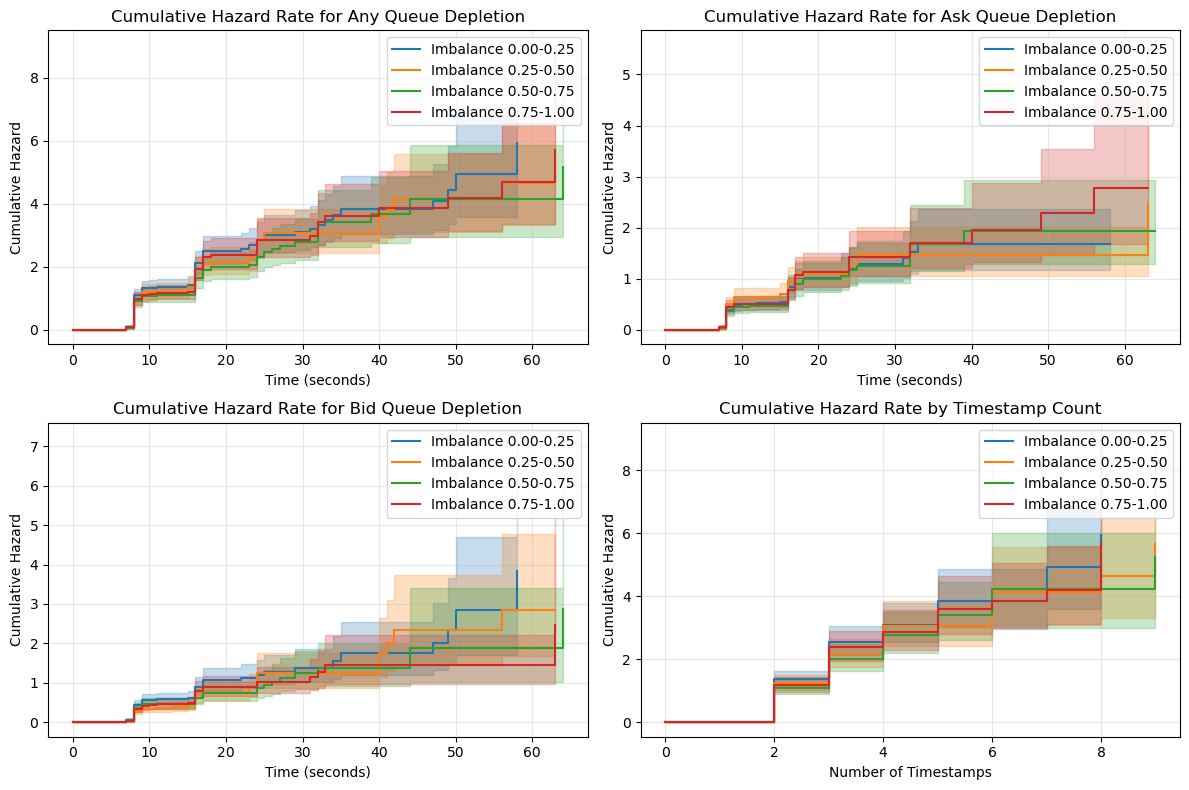

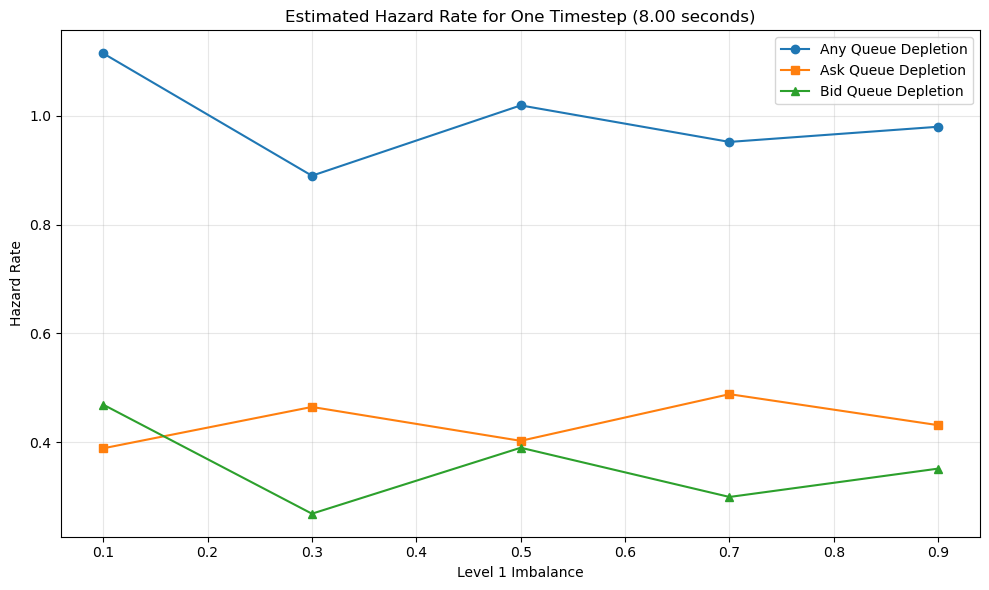

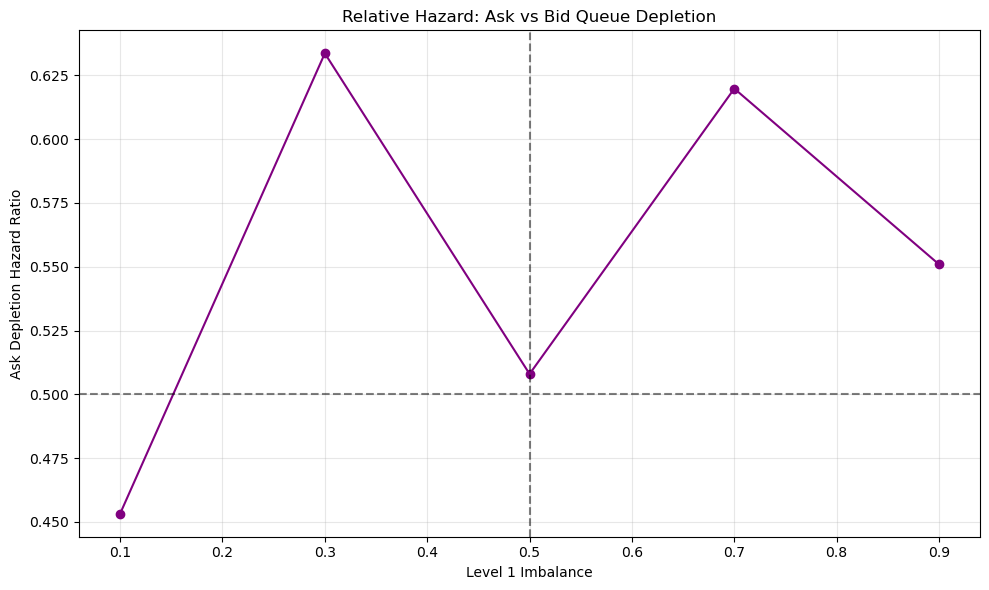

In [215]:
hazard_results = analyze_queue_depletion_hazard(dfs)
plot_queue_depletion_hazard(hazard_results)

In [217]:
hazard_results['one_step_hazard']

,imbalance,any_depletion_hazard,ask_depletion_hazard,bid_depletion_hazard
0,0.1,1.114476,0.388944,0.469223
1,0.3,0.889663,0.464948,0.268830
2,0.5,1.018870,0.402684,0.390026
3,0.7,0.951777,0.488418,0.299582
4,0.9,0.979648,0.431432,0.351682
